# Chicago boundaries

In this notebook, we'll look at two ways that areas in Chicago are collected into "regions" and "sides", and then save this collated data as shapefiles for use elsewhere.

- The main "area" data is avilable from the City of Chicago data website: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6
- The classification into "regions" can be found e.g. here: https://www.cityofchicago.org/dam/city/depts/cdph/policy_planning/PP_PlanningRegions101810.pdf
- The classification into "sides" can be found e.g. here: https://en.wikipedia.org/wiki/Community_areas_in_Chicago

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import os

The file `Chicago_Areas.geojson` is downloaded from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

In [2]:
filename = os.path.join("..", "..", "..", "..", "Data", "Chicago_Areas.geojson")
frame = gpd.read_file(filename)
frame.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,geometry,perimeter,shape_area,shape_len
0,0,35,35,0,0,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,0,46004621.1581,31027.0545098
1,0,36,36,0,0,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...,0,16913961.0408,19565.5061533
2,0,37,37,0,0,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,0,19916704.8692,25339.0897503
3,0,38,38,0,0,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...,0,48492503.1554,28196.8371573
4,0,39,39,0,0,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...,0,29071741.9283,23325.1679062


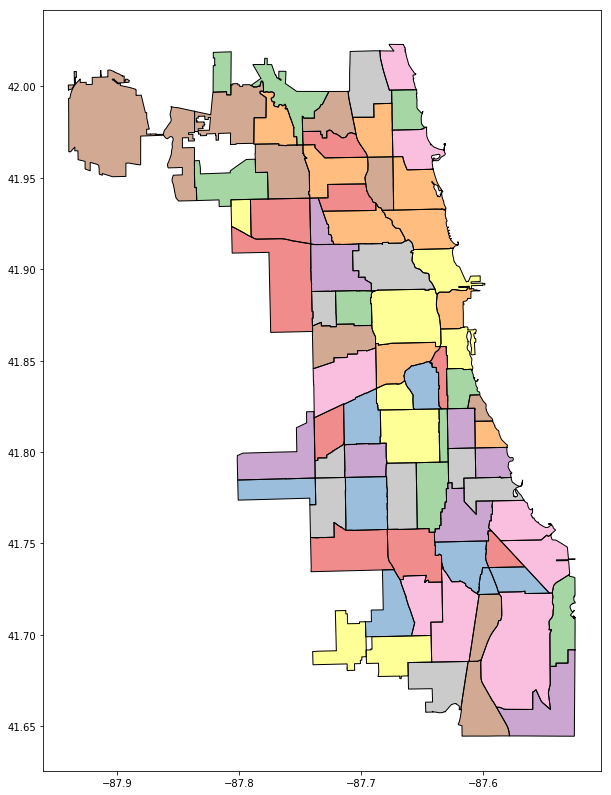

In [3]:
fig, ax = plt.subplots(figsize=(10,14))
_ = frame.plot(ax=ax, column="community")

In [4]:
regions_mapping = {
    "North" : [1,2,3,4,5,6,7,77],
    "Northwest" : list(range(9,23)) + [76],
    "West" : list(range(23,32)),
    "Central" : [8, 32, 33],
    "South" : [35, 36] + list(range(38, 49)) + [69],
    "Southwest" : [34, 37] + list(range(56, 69)) + [70],
    "FarSouth" : list(range(49, 56)) + list(range(71, 76))
}

In [5]:
def get_region(x):
    return next( key for key, item in regions_mapping.items() if int(x) in item )
        
frame["region"] = frame.area_numbe.map(get_region)

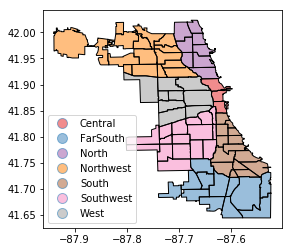

In [6]:
_ = frame.plot(column="region", legend=True)

## Visualise the regions with a basemap

We'll project to "web mercator" and use `tilemapbase` to view the regions with an OpenStreetMap derived basemap.

In [7]:
frame = frame.to_crs({"init":"epsg:3857"})

In [8]:
import tilemapbase

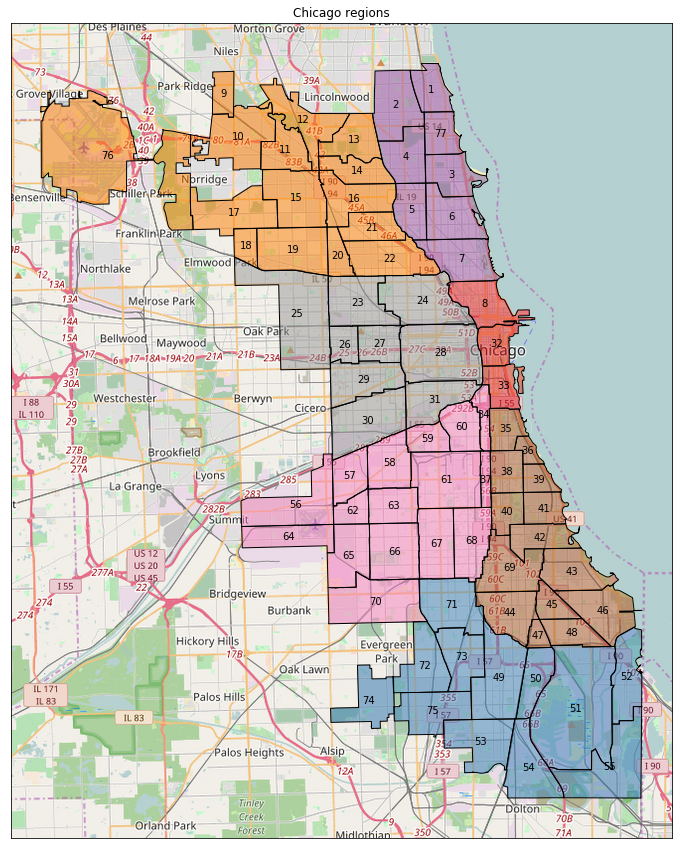

In [9]:
extent = tilemapbase.extent_from_frame(frame, 1000, 5)

fig, ax = plt.subplots(figsize=(14,15))
extent.plot(ax, tilemapbase.tiles.OSM, alpha=1)
frame.plot(ax=ax, column="region", alpha=0.5)
for _, row in frame.iterrows():
    x, y = row.geometry.centroid.coords[0]
    ax.text(x, y, row.area_numbe, horizontalalignment='center', verticalalignment='center')
ax.set_title("Chicago regions")
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_aspect(1)
None

# From wikipedia instead

https://en.wikipedia.org/wiki/Community_areas_in_Chicago

Fortunately seems to have the same numbering!

In [10]:
side_mapping = {
    "Far North" : [1,2,3,4,9,10,11,12,13,14,76,77],
    "Northwest" : [15,16,17,18,19,20],
    "North" : [5,6,7,21,22],
    "West" : list(range(23, 32)),
    "Central" : [8,32,33],
    "South" : list(range(34,44)) + [60, 69],
    "Southwest" : [56,57,58,59] + list(range(61,69)),
    "Far Southwest" : list(range(70,76)),
    "Far Southeast" : list(range(44,56))
}

In [11]:
frame["side"] = frame.area_numbe.map(lambda x : next(key
    for key, item in side_mapping.items() if int(x) in item) )

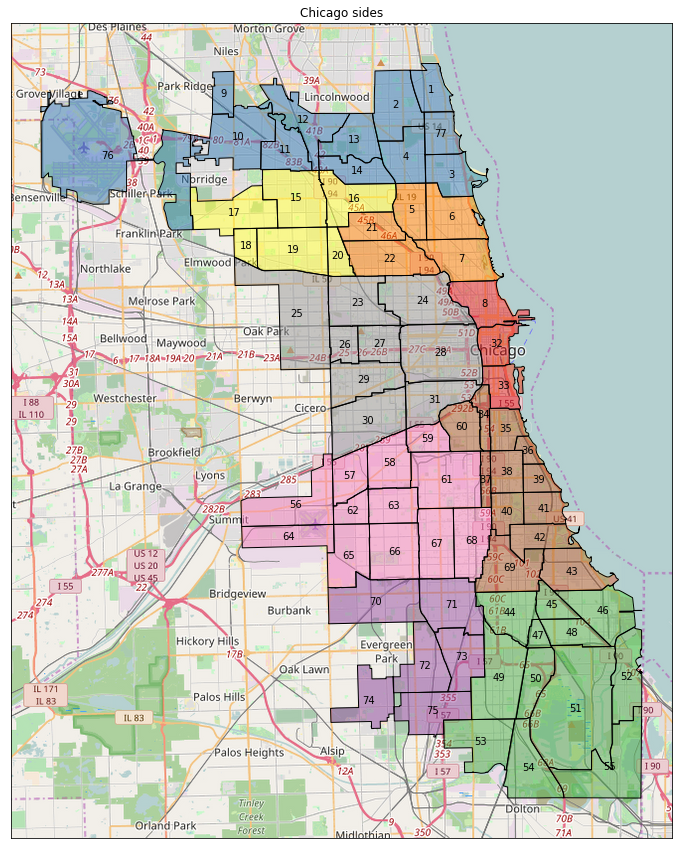

In [12]:
fig, ax = plt.subplots(figsize=(14,15))
extent.plot(ax, tilemapbase.tiles.OSM, alpha=1)
frame.plot(ax=ax, column="side", alpha=0.5)
for _, row in frame.iterrows():
    x, y = row.geometry.centroid.coords[0]
    ax.text(x, y, row.area_numbe, horizontalalignment='center', verticalalignment='center')
ax.set_title("Chicago sides")
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_aspect(1)
None

# Extract and save as shapefiles

In [19]:
regions = frame.drop(["area", "area_num_1", "comarea", "comarea_id",
                        "perimeter", "shape_area", "shape_len", "side"], axis=1)
old_columns = list(regions.columns)
old_columns[0] = "area_numbers"
regions.columns = old_columns
regions = regions.to_crs({'init': 'EPSG:4326'})
regions.head()

,area_numbers,community,geometry,region
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,South
1,36,OAKLAND,(POLYGON ((-87.59215283879392 41.8169293462668...,South
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,Southwest
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057217...,South
4,39,KENWOOD,(POLYGON ((-87.59215283879392 41.8169293462668...,South


In [20]:
regions.to_file( "Chicago_Regions" )

In [21]:
sides = frame.drop(["area", "area_num_1", "comarea", "comarea_id",
                        "perimeter", "shape_area", "shape_len", "region"], axis=1)
old_columns = list(sides.columns)
old_columns[0] = "area_numbers"
sides.columns = old_columns
sides = sides.to_crs({'init': 'EPSG:4326'})
sides.head()

,area_numbers,community,geometry,side
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,South
1,36,OAKLAND,(POLYGON ((-87.59215283879392 41.8169293462668...,South
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,South
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057217...,South
4,39,KENWOOD,(POLYGON ((-87.59215283879392 41.8169293462668...,South


In [22]:
sides.to_file( "Chicago_Sides" )